## Imports

In [211]:
import torch
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, TextGenerationPipeline, GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from datasets import load_dataset, load_from_disk

import chess
import chess.svg

from tqdm import tqdm
from copy import deepcopy
from math import ceil
from utils.utils import get_stockfish_scores

from IPython.display import SVG, display

import warnings
warnings.filterwarnings("ignore")

In [175]:
board_data = "data/test.csv.gz"
moves_data = "data/subset_games"
stockfish_path = r"C:\Users\barte\Desktop\Studies\chess_bot\PikeBot\engine\stockfish\stockfish-windows-x86-64-avx2.exe"
stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [176]:
WHITE = 0
BLACK = 1

## Data

In [177]:
## dataset = load_dataset("adamkarvonen/chess_games") # Big
# dataset = load_dataset("mlabonne/chessllm")

In [178]:
# dataset["train"]

In [179]:
# dataset["train"][0]

In [180]:
# subset = dataset["train"].select(range(1000))
# subset.save_to_disk("data/subset_games")

In [181]:
test_data_moves = load_from_disk(moves_data)
test_data_moves

Dataset({
    features: ['average_elo', 'transcript'],
    num_rows: 1000
})

In [182]:
test_data_moves[0]

{'average_elo': 1500.0,
 'transcript': '1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1'}

In [183]:
test_data = pd.read_csv(board_data, compression='gzip')

In [184]:
test_data.sort_values(["game_number", "move_number"])

,game_number,move_number,board,move,legal,stockfish_2,stockfish_5,stockfish_10,real,piece_placement,active_color,castling_availability,en_passant,halfmove_clock,fullmove_number
443,0,1,rnbqkbnr/pppppppp/8/8/8/8/RPPPPPPP/RNBQKBN1 b ...,h1a2,False,NaN,NaN,NaN,False,rnbqkbnr/pppppppp/8/8/8/8/RPPPPPPP/RNBQKBN1,b,Qkq,-,0,1
852,0,1,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,e2e4,True,19.0,7.0,13.0,True,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR,b,KQkq,-,0,1
155,0,2,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,e7e6,True,-37.0,-37.0,-34.0,True,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR,w,KQkq,-,0,2
203,0,2,rnbqkbnr/pppppppp/8/6n1/4P3/8/PPPP1PPP/R1BQKBN...,b1g5,False,NaN,NaN,NaN,False,rnbqkbnr/pppppppp/8/6n1/4P3/8/PPPP1PPP/R1BQKBNR,w,KQkq,-,0,2
340,0,3,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,d2d4,True,13.0,9.0,19.0,True,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR,b,KQkq,-,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,9,88,8/5pk1/6b1/8/8/Qp3P2/2q3P1/6K1 w - - 2 45,c3c2,True,442.0,312.0,552.0,True,8/5pk1/6b1/8/8/Qp3P2/2q3P1/6K1,w,-,-,2,45
39,9,89,8/5pk1/6b1/8/8/Qp3P2/6P1/6KQ b - - 0 45,c2h1,False,NaN,NaN,NaN,False,8/5pk1/6b1/8/8/Qp3P2/6P1/6KQ,b,-,-,0,45
511,9,89,8/5pk1/6b1/8/8/Qp3P2/2q3PK/8 b - - 3 45,g1h2,True,-644.0,-572.0,-546.0,True,8/5pk1/6b1/8/8/Qp3P2/2q3PK/8,b,-,-,3,45
387,9,90,8/5pk1/6b1/8/8/Qpp5/2q3PK/8 w - - 0 46,f3c3,False,NaN,NaN,NaN,False,8/5pk1/6b1/8/8/Qpp5/2q3PK/8,w,-,-,0,46


## Utils

#### General functions

In [223]:
def show_board(board, size=400):
    display(SVG(chess.svg.board(board=board, size=size)))

def get_n_moves(game_transcript, n=10):
    n_games = n + ceil(n/2)
    try:
        return " ".join(game_transcript.split(" ")[:n_games])
    except IndexError:
        return None
    
def get_state_after_moves(game_transcript, n=10):
    board = chess.Board()
    game_str = get_n_moves(game_transcript, n)
    if game_str is None:
        return None, None
    
    game = [x for x in game_str.split(" ") if x[0].isalpha()]
    for move in game:
        if move in set(get_san_legal_moves(board)):
            board.push_san(move)
        
    return board, game_str

def generate_answer(generator, prompt, max_len=40, num_answers=1, alternatives=None):
    answer = None
    if alternatives is None:
        answer = generator(prompt, max_length=max_len, num_return_sequences=num_answers,
                truncation=True, pad_token_id=generator.tokenizer.eos_token_id)
    else:
        answer = generator(prompt, max_length=max_len, num_return_sequences=num_answers,
                truncation=True, pad_token_id=generator.tokenizer.eos_token_id, force_words=alternatives,
                num_beams=4)
        
    return [x["generated_text"] for x in answer]

def generate_next_moves(moves, generator, tokenizer, answer_length=20, num_answers=1, alternatives=None):
    query = f"Provide the next move in the chess game. Only provide the move, no move numbers. {moves}"
    tokens = tokenizer.tokenize(query)

    answers = generate_answer(generator, query, max_len=len(tokens)+answer_length, num_answers=num_answers, alternatives=alternatives)
    return [answer[len(query)+1:].strip() for answer in answers]

def get_san_legal_moves(board):
    return [board.san(move) for move in board.legal_moves]

def get_color(board_turn):
    return "WHITE" if chess.WHITE == board_turn else "BLACK"

def get_legal_move_evaluations(board, engine, plot_evaluations=False):
    results = {}
    player = board.turn

    result = engine.analyse(board, chess.engine.Limit(time=0.1))
    prev_score = result["score"].pov(color=player).score(mate_score=900)
    # print("Score before move:", prev_score)
    results["prev_score"] = prev_score

    moves = []
    scores_diff = []
    legal_moves = get_san_legal_moves(board)
    if len(legal_moves) == 0:
        # print("No legal moves, skipping")
        return None

    for move in legal_moves:
        board_copy = board.copy()
        board_copy.push_san(move)
        
        result = engine.analyse(board_copy, chess.engine.Limit(time=0.05))
        evaluation_score = result["score"].pov(color=player).score(mate_score=900)
            
        moves.append(move)
        scores_diff.append(evaluation_score - prev_score)
        # print("Move:", move, "Score:", evaluation_score)
        
    scores_diff = np.array(scores_diff)
    scores_mean = np.mean(scores_diff)
    scores_min = min(scores_diff)
    scores_max = max(scores_diff)

    move_min = moves[np.argmin(scores_diff)]
    move_max = moves[np.argmax(scores_diff)]

    # print(f"Best move: {move_max}: {scores_max} | Worst move: {move_min}: {scores_min} | Mean score {scores_mean}")
    results["best_move"] = move_max
    results["worst_move"] = move_min
    results["min_score"] = scores_min
    results["max_score"] = scores_max
    results["mean_score"] = scores_mean

    sorted_moves_evaluations = sorted(zip(moves, scores_diff), key=lambda x: x[1], reverse=True)
    sorted_moves, sorted_evaluations = zip(*sorted_moves_evaluations)

    results["sorted_moves"] = list(sorted_moves)
    results["sorted_diff_scores"] = list(sorted_evaluations)

    if plot_evaluations:
        plt.figure(figsize=(14, 5))
        plt.bar(sorted_moves, sorted_evaluations)
        plt.xlabel('Moves')
        plt.ylabel('Score difference')
        plt.title('Sorted Evaluation Differences and Corresponding Moves')
        plt.xticks(rotation=45)
        plt.show()

    return results

def plot_results_hist(scores, min_score, max_score, title=""):
    num_bins = 10
    bin_edges = np.linspace(min_score, max_score, num_bins + 1)

    hist, bins = np.histogram(scores, bins=bin_edges)

    plt.figure(figsize=(5, 4))
    plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
    plt.xlabel('Score difference')
    plt.ylabel('Frequency')
    plt.title(f'Histogram {title}')
    plt.grid(axis='y')
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    
    plt.yticks(np.arange(0, max(hist) + 1, 1))
    plt.show()

#### Single move tests

In [172]:
def eval_single_position_bot(board, moves, move_stats, generator, tokenizer, num_answers=100, verbose=False):
    """
    Evaluates multiple answers for a single position

    Parameters:
     - board: chess.Board generated with get_state_after_moves()
     - moves: corresponding moves generated with get_state_after_moves()
     - move_stats: stockfish move evaluations created with get_legal_move_evaluations()
     - generator: generator pipeline
     - tokenizer: tokenizer
     - num_answers: number of evaluated answers
     - verbose: print evaluation info
    """
    performances = {
        "illegal_moves": 0,
        "legal_moves": 0,
        "above_average_moves": 0,
        "worst_moves": 0,
        "best_moves": 0,
        "diff_scores": None
    }
    player = board.turn

    scores = []
    answers = generate_next_moves(moves, generator, tokenizer, answer_length=10, num_answers=num_answers)
    legal_moves = get_san_legal_moves(board)
    for next_moves in answers:
        try:
            next_moves = [move for move in next_moves.split(" ") if move[0].isalpha()]
        except IndexError: # Assume fail if this fails - no clear move in answer
            next_moves = []

        if len(next_moves) == 0:
            if verbose:
                print("No valid moves")
            performances["illegal_moves"] += 1
            continue

        next_move = next_moves[0]
        if verbose:
            print(f"\nGPT Player: {get_color(player)} | Move(?): {next_move} | In legal moves: {next_move in legal_moves}")

        if next_move in legal_moves:
            performances["legal_moves"] += 1

            board_copy = board.copy()
            board_copy.push_san(next_move)
            result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.05))
            evaluation_score = result["score"].pov(color=player).score(mate_score=900)
            evaluation_diff = evaluation_score - move_stats['prev_score']
            
            if verbose:
                print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move==move_stats['best_move']}\n - Is worst move: {next_move==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}")
            
            scores.append(evaluation_diff)
            if next_move==move_stats['best_move']:
                performances["best_moves"] += 1
            
            if next_move==move_stats['worst_move']:
                performances["worst_moves"] += 1
                
            if evaluation_diff > move_stats['mean_score']:
                performances["above_average_moves"] += 1

        else:
            performances["illegal_moves"] += 1

    performances["diff_scores"] = scores
    return performances


def eval_single_position_random(board, move_stats, num_answers=100, verbose=False):
    """
    Evaluates multiple answers for a single position using a random player

    Parameters:
     - board: chess.Board generated with get_state_after_moves()
     - move_stats: stockfish move evaluations created with get_legal_move_evaluations()
     - num_answers: number of evaluated answers
     - verbose: print evaluation info
    """
    performances_random = {
        "above_average_moves": 0,
        "worst_moves": 0,
        "best_moves": 0,
        "diff_scores": None
    }
    player = board.turn

    scores = []
    legal_moves = get_san_legal_moves(board)
    answers = random.choices(legal_moves, k=num_answers)
    for next_move in answers:
        if verbose:
            print(f"\Random Player: {get_color(player)} | Move(?): {next_move}")

        board_copy = board.copy()
        board_copy.push_san(next_move)
        result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.05))
        evaluation_score = result["score"].pov(color=player).score(mate_score=900)
        evaluation_diff = evaluation_score - move_stats['prev_score']
        
        if verbose:
            print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move==move_stats['best_move']}\n - Is worst move: {next_move==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}")
        
        scores.append(evaluation_diff)
        if next_move==move_stats['best_move']:
            performances_random["best_moves"] += 1
        
        if next_move==move_stats['worst_move']:
            performances_random["worst_moves"] += 1
            
        if evaluation_diff > move_stats['mean_score']:
            performances_random["above_average_moves"] += 1

    performances_random["diff_scores"] = scores
    return performances_random

def run_single_game_eval(transcripts, num_moves, num_answers, stockfish, generator, tokenizer, print_conclusions=False, show_plots=False):
    """
    Runs a tests for single game move analysis. For each transcript, num_moves are played and num_answers to the move generated by the model.
    Moves are evaluated by stockfish and the results printed/plotted. An aggregate of best/worst moves and average difference scores for evaluated games is returned.
    
    Parameters:
    - transcripts: transcripts of games to be used
    - num_moves: number of moves from the games to be played before evaluation move
    - num_answers: number of model answers generated
    - stockfish: stockfish chess.SimpleEngine
    - generator: pipeline generator
    - tokenizer: model's tokenizer
    - print_conclusions: display conclusions
    - show_plots: display plots
    """
    avg_scores_gpt = []
    avg_scores_random = []
    total_performance_gpt = {
        "total_best_moves": 0,
        "total_worst_moves": 0,
        "total_above_average_moves": 0,
        "total_illegal_moves": 0,
        "total_legal_moves": 0,
        "avg_diff_scores": None
    }
    total_performance_random = {
        "total_best_moves": 0,
        "total_worst_moves": 0,
        "total_above_average_moves": 0,
        "avg_diff_scores": None
    }

    for i, transcript in enumerate(transcripts):
        if print_conclusions:
            print("===============================================================================")
            print(f"Game {i} | Number of moves: {num_moves} | Evaluated answers: {num_answers}")
            print("===============================================================================")
        # Get the board and move string after num_moves of the transcripted game
        board, moves = get_state_after_moves(transcript, num_moves)
        if board is None:
            print(f"{num_moves} is too many moves for game {i}, skipping...")
            continue

        if show_plots:
            show_board(board, 300)

        # Get the stats of possible legal moves
        move_stats = get_legal_move_evaluations(board, stockfish, plot_evaluations=show_plots)
        if move_stats is None:
            continue

        if print_conclusions:
            print(f'''
 Worst move: {move_stats["worst_move"]} score difference: {move_stats["min_score"]}
 Best move: {move_stats["best_move"]} score difference: {move_stats["max_score"]}
 Mean difference score: {move_stats["mean_score"]}
            ''')

        # Get stats for gpt model
        performances = eval_single_position_bot(board, moves, move_stats, generator, tokenizer, num_answers=num_answers)
        if print_conclusions:
            print(f'''-----------------------------------------------------------------------------------
 GPT-2 results:
    - Legal moves made: {performances["legal_moves"]} / {num_answers}
    - Number of times the worst move was made: {performances["worst_moves"]}
    - Number of times the best move was made: {performances["best_moves"]}
    - Number of times an above average move was made: {performances["above_average_moves"]}
            ''')

        if performances["legal_moves"] > 0:
            avg_scores_gpt.append(np.mean(performances["diff_scores"]))

        total_performance_gpt["total_above_average_moves"] += performances["above_average_moves"]
        total_performance_gpt["total_best_moves"] += performances["best_moves"]
        total_performance_gpt["total_worst_moves"] += performances["worst_moves"]
        total_performance_gpt["total_illegal_moves"] += performances["illegal_moves"]
        total_performance_gpt["total_legal_moves"] += performances["legal_moves"]

        if show_plots:
            plot_results_hist(performances["diff_scores"], move_stats["min_score"], move_stats["max_score"], "GPT-2")

        # Get stats for random choice (num repetitions equal to num legal moves made by gpt model)
        if performances["legal_moves"] > 0:
            performances_random = eval_single_position_random(board, move_stats, performances["legal_moves"])
            if print_conclusions:
                print(f'''-----------------------------------------------------------------------------------
 Random results:
    - Number of times the worst move was made: {performances_random["worst_moves"]}
    - Number of times the best move was made: {performances_random["best_moves"]}
    - Number of times an above average move was made: {performances_random["above_average_moves"]}
                ''')
            avg_scores_random.append(np.mean(performances_random["diff_scores"]))
            total_performance_random["total_above_average_moves"] += performances_random["above_average_moves"]
            total_performance_random["total_best_moves"] += performances_random["best_moves"]
            total_performance_random["total_worst_moves"] += performances_random["worst_moves"]

            if show_plots:
                plot_results_hist(performances_random["diff_scores"], move_stats["min_score"], move_stats["max_score"], "Random")
        elif print_conclusions:
            print(f'''-----------------------------------------------------------------------------------
 Random results not generated, no legal moves made by the bot
            ''')

    total_performance_gpt["avg_diff_scores"] = avg_scores_gpt
    total_performance_random["avg_diff_scores"] = avg_scores_random

    return total_performance_gpt, total_performance_random

def show_results_single_eval(summaries, tests_num_moves, plot_hist=True):
    aggregate_summary_bot = {
        "agg_legal": 0,
        "agg_illegal": 0,
        "agg_best": 0,
        "agg_worst": 0,
        "agg_above_average": 0
    }

    aggregate_summary_random = {
        "agg_legal": 0,
        "agg_illegal": 0,
        "agg_best": 0,
        "agg_worst": 0,
        "agg_above_average": 0
    }

    plot_hist = True

    avg_scores_bot = []
    avg_scores_random = []
    for num_moves in tests_num_moves:
        print("========================================================================")
        print(f"Number of moves before evaluation: {num_moves}")
        print("---------------------------------------\nGPT-2:")
        avg_bot = summaries[num_moves]["gpt"]["avg_diff_scores"]
        avg_score_bot = np.mean(avg_bot)
        avg_scores_bot.append(avg_score_bot)
        print(f' - Average score difference after move: {avg_score_bot}')
        print(f' - Total number of legal moves: {summaries[num_moves]["gpt"]["total_legal_moves"]} / {(summaries[num_moves]["gpt"]["total_legal_moves"]+summaries[num_moves]["gpt"]["total_illegal_moves"])}')
        print(f' - Total number of best moves: {summaries[num_moves]["gpt"]["total_best_moves"]}')
        print(f' - Total number of worst moves: {summaries[num_moves]["gpt"]["total_worst_moves"]}')
        print(f' - Total number of above average moves: {summaries[num_moves]["gpt"]["total_above_average_moves"]}')

        if plot_hist:
            plot_results_hist(avg_bot, min(avg_bot), max(avg_bot), f"GPT {num_moves} moves average score difference")

        print("---------------------------------------\nRandom:")
        avg_random = summaries[num_moves]["random"]["avg_diff_scores"]
        avg_score_random = np.mean(avg_random)
        avg_scores_random.append(avg_score_random)
        print(f' - Average score difference after move: {avg_score_random}')
        print(f' - Total number of best moves: {summaries[num_moves]["random"]["total_best_moves"]}')
        print(f' - Total number of worst moves: {summaries[num_moves]["random"]["total_worst_moves"]}')
        print(f' - Total number of above average moves: {summaries[num_moves]["random"]["total_above_average_moves"]}')

        if plot_hist:
            plot_results_hist(avg_random, min(avg_random), max(avg_random), f"Random {num_moves} moves average score difference")

        aggregate_summary_bot["agg_legal"] += summaries[num_moves]["gpt"]["total_legal_moves"]
        aggregate_summary_bot["agg_illegal"] += summaries[num_moves]["gpt"]["total_illegal_moves"]
        aggregate_summary_bot["agg_best"] += summaries[num_moves]["gpt"]["total_best_moves"]
        aggregate_summary_bot["agg_worst"] += summaries[num_moves]["gpt"]["total_worst_moves"]
        aggregate_summary_bot["agg_above_average"] += summaries[num_moves]["gpt"]["total_above_average_moves"]

        aggregate_summary_random["agg_best"] += summaries[num_moves]["random"]["total_best_moves"]
        aggregate_summary_random["agg_worst"] += summaries[num_moves]["random"]["total_worst_moves"]
        aggregate_summary_random["agg_above_average"] += summaries[num_moves]["random"]["total_above_average_moves"]

    print("===============================================================")
    print("Aggregate results GPT-2")
    print(f' - Average score difference after move: {np.mean(avg_scores_bot)}')
    print(f' - Total number of legal moves: {aggregate_summary_bot["agg_legal"]} / {aggregate_summary_bot["agg_illegal"]+aggregate_summary_bot["agg_legal"]}')
    print(f' - Total number of best moves: {aggregate_summary_bot["agg_best"]}')
    print(f' - Total number of worst moves: {aggregate_summary_bot["agg_worst"]}')
    print(f' - Total number of above average moves: {aggregate_summary_bot["agg_above_average"]}')

    print("----------------------------------------------------------------")
    print("Aggregate results Random")
    print(f' - Average score difference after move: {np.mean(avg_scores_random)}')
    print(f' - Total number of best moves: {aggregate_summary_random["agg_best"]}')
    print(f' - Total number of worst moves: {aggregate_summary_random["agg_worst"]}')
    print(f' - Total number of above average moves: {aggregate_summary_random["agg_above_average"]}')

#### Forced legal moves tests

In [261]:
def run_legal_forced_test(transcripts, num_moves, stockfish, generator, forced_generator, verbose=False):
    summaries = dict([[x, {"gpt": None, "gpt_forced": None, "random": None}] for x in num_moves])

    for n_moves in num_moves:
        print(f"Tests for {n_moves} moves")

        performance_forced = {
            "illegal_moves": 0,
            "legal_moves": 0,
            "above_average_moves": 0,
            "worst_moves": 0,
            "best_moves": 0,
            "diff_scores": None
        }
        performance_normal = deepcopy(performance_forced)
        performance_random = deepcopy(performance_forced)

        scores_forced = []
        scores_normal = []
        scores_random = []
        for i, transcript in tqdm(enumerate(transcripts), total=len(transcripts)):    
            if verbose:
                print("------------------------------------------------------")   
                print("Game", i)

            board, moves = get_state_after_moves(transcript, n_moves)
            move_stats = get_legal_move_evaluations(board, stockfish)
            legal_moves = get_san_legal_moves(board)

            if len(legal_moves) == 0 or legal_moves is None:
                if verbose:
                    print("No legal moves, skipping")
                
                continue

            player = board.turn

            #### Forced legal moves -------------------------------------------------------
            if verbose:
                print("GPT FORCED")

            try:
                answer_forced = generate_next_moves(moves, forced_generator, forced_generator.tokenizer, 10, alternatives=legal_moves)[0]
            except ValueError: # Skip game on issue with `nested_token_ids`
                continue

            try:
                next_moves_forced = [move for move in answer_forced.split(" ") if move[0].isalpha()]
            except IndexError: # Assume fail if this fails - no clear move in answer
                next_moves_forced = []

            if len(next_moves_forced) != 0:
                next_move_forced = next_moves_forced[0]
                
                if next_move_forced in legal_moves:
                    performance_forced["legal_moves"] += 1

                    board_copy = board.copy()
                    board_copy.push_san(next_move_forced)
                    result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.05))
                    evaluation_score = result["score"].pov(color=player).score(mate_score=900)
                    evaluation_diff = evaluation_score - move_stats['prev_score']
                    
                    if verbose:
                        print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move_forced==move_stats['best_move']}\n - Is worst move: {next_move_forced==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}\n")
                    
                    scores_forced.append(evaluation_diff)
                    if next_move_forced==move_stats['best_move']:
                        performance_forced["best_moves"] += 1
                    
                    if next_move_forced==move_stats['worst_move']:
                        performance_forced["worst_moves"] += 1
                        
                    if evaluation_diff > move_stats['mean_score']:
                        performance_forced["above_average_moves"] += 1

                else:
                    performance_forced["illegal_moves"] += 1

            else:
                next_move_forced = "none" # To stop random calculation
                performance_forced["illegal_moves"] += 1
                
                if verbose:
                    print(" ILLEGAL MOVE\n")

            #### No forced legal moves -------------------------------------------------------
            if verbose:
                print("GPT NORMAL")

            answer_normal = generate_next_moves(moves, generator, generator.tokenizer, 10)[0]

            try:
                next_moves_normal = [move for move in answer_normal.split(" ") if move[0].isalpha()]
            except IndexError: # Assume fail if this fails - no clear move in answer
                next_moves_normal = []

            if len(next_moves_normal) != 0:
                next_move_normal = next_moves_normal[0]

                if next_move_normal in legal_moves:
                    performance_normal["legal_moves"] += 1

                    board_copy = board.copy()
                    board_copy.push_san(next_move_normal)
                    result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.05))
                    evaluation_score = result["score"].pov(color=player).score(mate_score=900)
                    evaluation_diff = evaluation_score - move_stats['prev_score']
                    
                    if verbose:
                        print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move_normal==move_stats['best_move']}\n - Is worst move: {next_move_normal==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}\n")
                    
                    scores_normal.append(evaluation_diff)
                    if next_move_normal==move_stats['best_move']:
                        performance_normal["best_moves"] += 1
                    
                    if next_move_normal==move_stats['worst_move']:
                        performance_normal["worst_moves"] += 1
                        
                    if evaluation_diff > move_stats['mean_score']:
                        performance_normal["above_average_moves"] += 1
                else:
                    performance_normal["illegal_moves"] += 1

            else:
                performance_normal["illegal_moves"] += 1

                if verbose:
                    print(" ILLEGAL MOVE\n")

            #### Random move (if legal move made by forced gpt) -------------------------------------------------------
            if verbose:
                print("RANDOM")

            if next_move_forced in legal_moves:
                next_move_random = random.choice(legal_moves)

                board_copy = board.copy()
                board_copy.push_san(next_move_random)
                result = stockfish.analyse(board_copy, chess.engine.Limit(time=0.05))
                evaluation_score = result["score"].pov(color=player).score(mate_score=900)
                evaluation_diff = evaluation_score - move_stats['prev_score']
                
                if verbose:
                    print(f" - Score before move: {move_stats['prev_score']}\n - Score after move: {evaluation_score}\n - Is best move: {next_move_random==move_stats['best_move']}\n - Is worst move: {next_move_random==move_stats['worst_move']}\n - Is above average move: {evaluation_diff > move_stats['mean_score']}\n")
                
                scores_random.append(evaluation_diff)
                if next_move_random==move_stats['best_move']:
                    performance_random["best_moves"] += 1
                
                if next_move_random==move_stats['worst_move']:
                    performance_random["worst_moves"] += 1
                    
                if evaluation_diff > move_stats['mean_score']:
                    performance_random["above_average_moves"] += 1

        performance_forced["diff_scores"] = scores_forced    
        performance_normal["diff_scores"] = scores_normal
        performance_random["diff_scores"] = scores_random

        summaries[n_moves]["gpt_forced"] = performance_forced
        summaries[n_moves]["gpt"] = performance_normal
        summaries[n_moves]["random"] = performance_random
    
    return summaries

def show_results_forced_test(summaries, tests_num_moves, plot_hist=True):
    aggregate_summary_bot_forced = {
        "agg_legal": 0,
        "agg_illegal": 0,
        "agg_best": 0,
        "agg_worst": 0,
        "agg_above_average": 0
    }

    aggregate_summary_bot = {
        "agg_legal": 0,
        "agg_illegal": 0,
        "agg_best": 0,
        "agg_worst": 0,
        "agg_above_average": 0
    }

    aggregate_summary_random = {
        "agg_best": 0,
        "agg_worst": 0,
        "agg_above_average": 0
    }

    plot_hist = True

    avg_scores_bot_forced = []
    avg_scores_bot = []
    avg_scores_random = []
    for num_moves in tests_num_moves:
        print("========================================================================")
        print(f"Number of moves before evaluation: {num_moves}")
        print("---------------------------------------\nGPT-2 FORCED ALTERNATIVES:")
        scores_bot_forced = summaries[num_moves]["gpt_forced"]["diff_scores"]

        if len(scores_bot_forced) > 0:
            avg_score_bot_forced = np.mean(scores_bot_forced)
            avg_scores_bot_forced.append(avg_score_bot_forced)
            print(f' - Average score difference after move: {avg_score_bot_forced}')

        print(f' - Total number of legal moves: {summaries[num_moves]["gpt_forced"]["legal_moves"]} / {(summaries[num_moves]["gpt_forced"]["legal_moves"]+summaries[num_moves]["gpt_forced"]["illegal_moves"])}')
        print(f' - Total number of best moves: {summaries[num_moves]["gpt_forced"]["best_moves"]}')
        print(f' - Total number of worst moves: {summaries[num_moves]["gpt_forced"]["worst_moves"]}')
        print(f' - Total number of above average moves: {summaries[num_moves]["gpt_forced"]["above_average_moves"]}')

        if plot_hist and len(scores_bot_forced) > 1:
            plot_results_hist(scores_bot_forced, min(scores_bot_forced), max(scores_bot_forced), f"GPT FORCED ALT {num_moves} moves average score difference")
        elif len(scores_bot_forced) == 0:
            print("No correct moves")

        print("---------------------------------------\nGPT-2 NORMAL:")
        scores_bot = summaries[num_moves]["gpt"]["diff_scores"]

        if len(scores_bot) > 0:
            avg_score_bot = np.mean(scores_bot)
            avg_scores_bot.append(avg_score_bot)
            print(f' - Average score difference after move: {avg_score_bot}')

        print(f' - Total number of legal moves: {summaries[num_moves]["gpt"]["legal_moves"]} / {(summaries[num_moves]["gpt"]["legal_moves"]+summaries[num_moves]["gpt"]["illegal_moves"])}')
        print(f' - Total number of best moves: {summaries[num_moves]["gpt"]["best_moves"]}')
        print(f' - Total number of worst moves: {summaries[num_moves]["gpt"]["worst_moves"]}')
        print(f' - Total number of above average moves: {summaries[num_moves]["gpt"]["above_average_moves"]}')

        if plot_hist and len(scores_bot) > 1:
            plot_results_hist(scores_bot, min(scores_bot), max(scores_bot), f"GPT NORM {num_moves} moves average score difference")
        elif len(scores_bot) == 0:
            print("No correct moves")

        if len(scores_bot_forced) > 0:
            print("---------------------------------------\nRandom:")
            avg_random = summaries[num_moves]["random"]["diff_scores"]
            avg_score_random = np.mean(avg_random)
            avg_scores_random.append(avg_score_random)
            print(f' - Average score difference after move: {avg_score_random}')
            print(f' - Total number of best moves: {summaries[num_moves]["random"]["best_moves"]}')
            print(f' - Total number of worst moves: {summaries[num_moves]["random"]["worst_moves"]}')
            print(f' - Total number of above average moves: {summaries[num_moves]["random"]["above_average_moves"]}')

            if plot_hist and len(scores_bot_forced) > 1:
                plot_results_hist(avg_random, min(avg_random), max(avg_random), f"Random {num_moves} moves average score difference")
        else:
            print("No correct forced model moves, no random comparison")
        
        aggregate_summary_bot_forced["agg_legal"] += summaries[num_moves]["gpt_forced"]["legal_moves"]
        aggregate_summary_bot_forced["agg_illegal"] += summaries[num_moves]["gpt_forced"]["illegal_moves"]
        aggregate_summary_bot_forced["agg_best"] += summaries[num_moves]["gpt_forced"]["best_moves"]
        aggregate_summary_bot_forced["agg_worst"] += summaries[num_moves]["gpt_forced"]["worst_moves"]
        aggregate_summary_bot_forced["agg_above_average"] += summaries[num_moves]["gpt_forced"]["above_average_moves"]

        aggregate_summary_bot["agg_legal"] += summaries[num_moves]["gpt"]["legal_moves"]
        aggregate_summary_bot["agg_illegal"] += summaries[num_moves]["gpt"]["illegal_moves"]
        aggregate_summary_bot["agg_best"] += summaries[num_moves]["gpt"]["best_moves"]
        aggregate_summary_bot["agg_worst"] += summaries[num_moves]["gpt"]["worst_moves"]
        aggregate_summary_bot["agg_above_average"] += summaries[num_moves]["gpt"]["above_average_moves"]

        aggregate_summary_random["agg_best"] += summaries[num_moves]["random"]["best_moves"]
        aggregate_summary_random["agg_worst"] += summaries[num_moves]["random"]["worst_moves"]
        aggregate_summary_random["agg_above_average"] += summaries[num_moves]["random"]["above_average_moves"]

    print("===============================================================")
    print("Aggregate results GPT-2 FORCED ALTERNATIVES")
    print(f' - Average score difference after move: {round(np.mean(avg_scores_bot_forced), 3)}')
    print(f' - Total number of legal moves: {aggregate_summary_bot_forced["agg_legal"]} / {aggregate_summary_bot_forced["agg_illegal"]+aggregate_summary_bot_forced["agg_legal"]}')
    print(f' - Total number of best moves: {aggregate_summary_bot_forced["agg_best"]}')
    print(f' - Total number of worst moves: {aggregate_summary_bot_forced["agg_worst"]}')
    print(f' - Total number of above average moves: {aggregate_summary_bot_forced["agg_above_average"]}')

    print("----------------------------------------------------------------")
    print("Aggregate results GPT-2 NORMAL")
    print(f' - Average score difference after move: {round(np.mean(avg_scores_bot), 3)}')
    print(f' - Total number of legal moves: {aggregate_summary_bot["agg_legal"]} / {aggregate_summary_bot["agg_illegal"]+aggregate_summary_bot["agg_legal"]}')
    print(f' - Total number of best moves: {aggregate_summary_bot["agg_best"]}')
    print(f' - Total number of worst moves: {aggregate_summary_bot["agg_worst"]}')
    print(f' - Total number of above average moves: {aggregate_summary_bot["agg_above_average"]}')

    print("----------------------------------------------------------------")
    print("Aggregate results Random")
    print(f' - Average score difference after move: {round(np.mean(avg_scores_random), 3)}')
    print(f' - Total number of best moves: {aggregate_summary_random["agg_best"]}')
    print(f' - Total number of worst moves: {aggregate_summary_random["agg_worst"]}')
    print(f' - Total number of above average moves: {aggregate_summary_random["agg_above_average"]}')

Play against a random player

In [272]:
def play_game_vs_random(start_transcript, num_start_moves, generator, max_iters=100, max_tries_bot=10, num_answers=10, verbose=False, display_board=False):
    board, moves = get_state_after_moves(start_transcript, num_start_moves)

    print("Starting position:")
    while max_iters > 0:
        if display_board:
            show_board(board)
        
        legal_moves = get_san_legal_moves(board)

        if len(legal_moves) == 0:
            if verbose:
                print(f"Game ended, winner: {get_color(1 if board.turn == 0 else 0)}")
            break

        move_made = False
        tries_bot = max_tries_bot
        while not move_made and tries_bot > 0:
            answers_bot = generate_next_moves(moves, generator, generator.tokenizer, answer_length=10, num_answers=num_answers)
            for next_moves in answers_bot:
                try:
                    next_moves = [move for move in next_moves.split(" ") if move[0].isalpha()]
                except IndexError: # Assume fail if this fails - no clear move in answer
                    next_moves = []

                if len(next_moves) == 0:
                    continue

                next_move = next_moves[0]   
                if next_move in legal_moves:
                    if verbose:
                        print(f"Player: GPT-2 | Color: {get_color(board.turn)} | Move: {next_move}")
                    board.push_san(next_move)
                    if display_board:
                        show_board(board)
                    
                    move_made = True
                    break
            tries_bot -= 1

        if not move_made:
            next_move = random.choice(new_legal_moves)
            if verbose:
                print("GPT move unsuccessful, picking random")
                print(f"Player: GPT-2 (random) | Color: {get_color(board.turn)} | Move: {next_move}")
            board.push_san(next_move)
            if display_board:
                show_board(board)
        
        new_legal_moves = get_san_legal_moves(board)

        if len(new_legal_moves) == 0:
            if verbose:
                print(f"Game ended, winner: {get_color(1 if board.turn == 0 else 0)}")

        next_move_random = random.choice(new_legal_moves)
        if verbose:
            print(f"Player: Random | Color: {get_color(board.turn)} | Move: {next_move_random}")

        board.push_san(next_move_random)
        
        max_iters -= 1


    if display_board:
        show_board(board)

## Model loading

In [14]:
device_name = torch.cuda.get_device_name(0)
print("Device 0:", device_name)

Device 0: NVIDIA GeForce RTX 3060 Ti


In [40]:
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("gpt2")
generator = pipeline("text-generation", model="gpt2", device=0) # TODO gpt2-xl
generator("Once upon a time,", max_length=40, truncation=True, pad_token_id=generator.tokenizer.eos_token_id)

[{'generated_text': 'Once upon a time, all three, having given up the search for a way, could no longer be found. Those who came, were thrown into hell or into an everlasting hell.\n\nBut'}]

In [75]:
model_config = generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups, model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size, model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1, True)
(1.0, 50)
(50, 0, False)
1



In [64]:
generate_answer(generator, "Once upon a time,", num_answers=2)

['Once upon a time, all my fellow Indians would be making a little noise while they walked by," he wrote to the late American scholar William Blake in 1815, "because men in the midst of',
 "Once upon a time, it said that these people who were born from God would have been able to see the sky.\n\n\nSo why doesn't we have that one?\n\nIt's because"]

## Evaluation based on previous moves

Assumptions:
- The first move in the answer is the next intended move.

#### TODO Ideas:
1. Evaluate multiple answers to the same situation - ***DONE*** - rerun required
    - calculate mean score improvement
    - number of worst/best moves
    - compare to stockfish evals
    - number of legal moves
    - compare to performance for situations closer and further from the beginning of the game (longer/shorter prompt moves context)
    
2. Constrict to legal moves by allowing for providing alternatives = legal moves, compare relevant results ***DONE***
3. Compare performance/game to a random move player ***DONE - NOT WORKING*** - *very hard to get a winner for gpt-2*
4. ~~Run as long as legal move not reached/only for legal moves, append move to prompt and evaluate again~~ *too long runtime*
5. Compare results to gpt2-xl **TODO important add and rerun tests at the end**
6. ~~Check how many consecutive legal moves can be found with increased max length output~~
7. ~~Experiment with beam search options~~
8. Check if changing the query e.g. Provide the *best* next move, Provide the *worst* next move changes quality of output. ***TODO***

#### Test 1: for a single situation analyse gpt answers

Using sampling to get multiple answers to a prompt.

Game 0 | Number of moves: 5 | Evaluated answers: 200


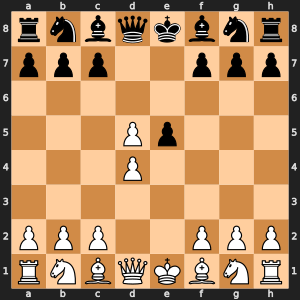

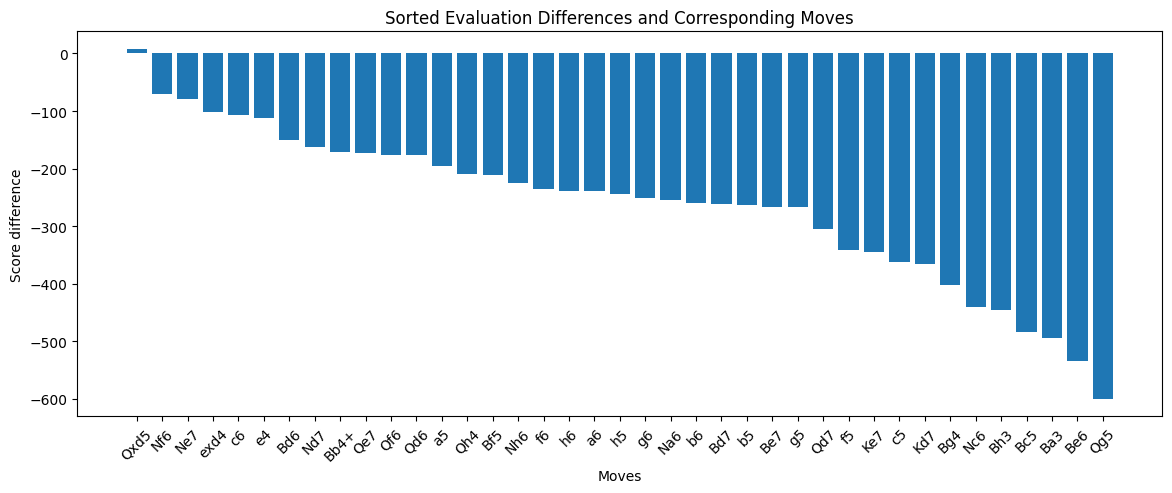


 Worst move: Qg5 score difference: -600
 Best move: Qxd5 score difference: 8
 Mean difference score: -262.0
            
-----------------------------------------------------------------------------------
 GPT-2 results:
    - Legal moves made: 34 / 200
    - Number of times the worst move was made: 0
    - Number of times the best move was made: 0
    - Number of times an above average move was made: 23
            


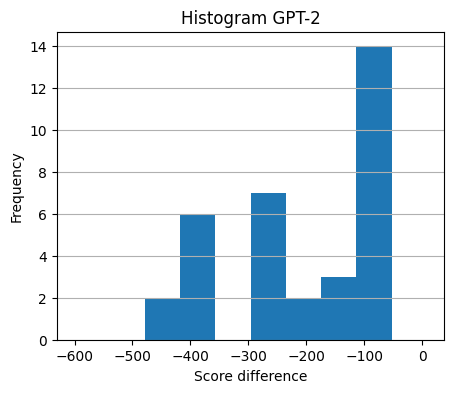

-----------------------------------------------------------------------------------
 Random results:
    - Number of times the worst move was made: 1
    - Number of times the best move was made: 4
    - Number of times an above average move was made: 20
                


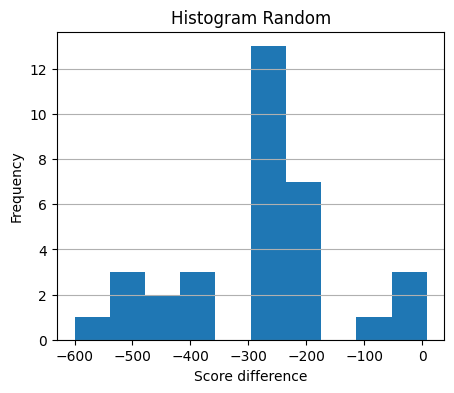

Game 1 | Number of moves: 5 | Evaluated answers: 200


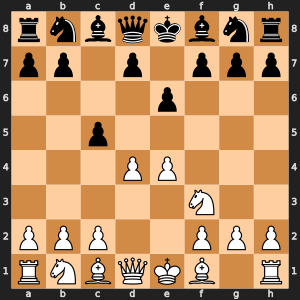

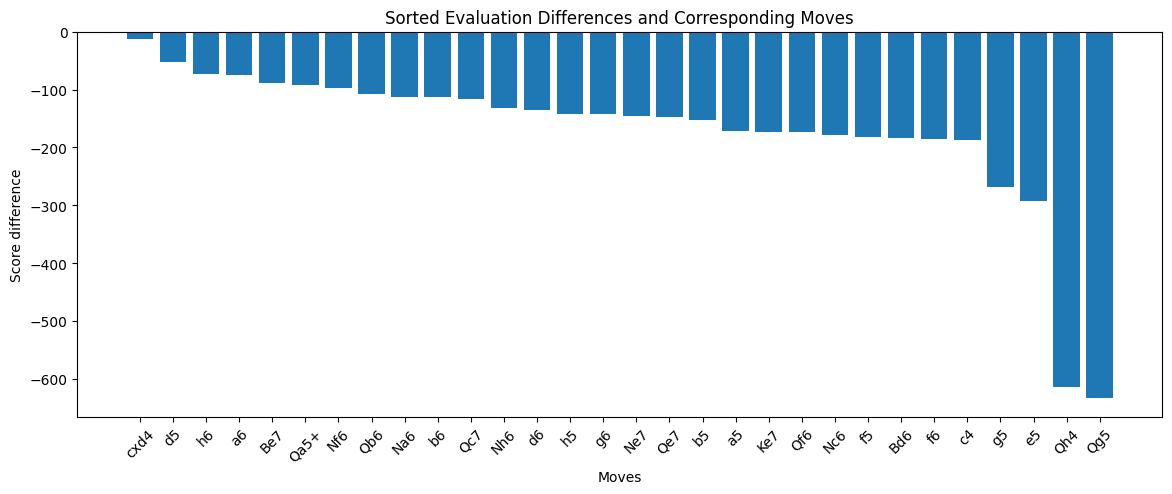


 Worst move: Qg5 score difference: -633
 Best move: cxd4 score difference: -12
 Mean difference score: -172.63333333333333
            
-----------------------------------------------------------------------------------
 GPT-2 results:
    - Legal moves made: 81 / 200
    - Number of times the worst move was made: 0
    - Number of times the best move was made: 11
    - Number of times an above average move was made: 71
            


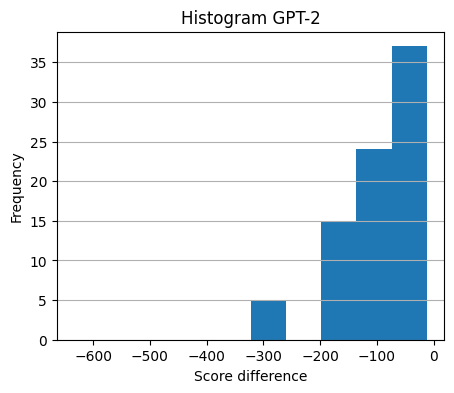

-----------------------------------------------------------------------------------
 Random results:
    - Number of times the worst move was made: 1
    - Number of times the best move was made: 5
    - Number of times an above average move was made: 46
                


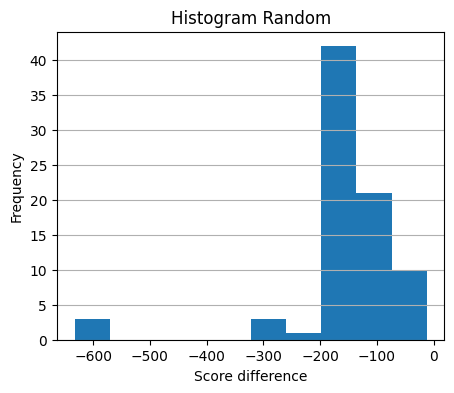

In [19]:
num_games = 2
transcripts = test_data_moves["transcript"][:num_games]
summary_gpt, summary_random = run_single_game_eval(transcripts, 5, 200, stockfish, generator, tokenizer, print_conclusions=True, show_plots=True)

In [20]:
num_games = 20
transcripts = test_data_moves["transcript"][:num_games]

num_answers = 200
tests_num_moves = [5, 10, 15, 20]

summaries = dict([[x, {"gpt": None, "random": None}] for x in tests_num_moves])
for num_moves in tests_num_moves:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Testing results after {num_moves} moves")
    summary_gpt, summary_random = run_single_game_eval(transcripts, num_moves, num_answers, stockfish, generator, tokenizer)
    summaries[num_moves]["gpt"] = summary_gpt
    summaries[num_moves]["random"] = summary_random

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 5 moves


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 10 moves
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 15 moves
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 20 moves


Number of moves before evaluation: 5
---------------------------------------
GPT-2:
 - Average score difference after move: -86.07554491702393
 - Total number of legal moves: 1185 / 4000
 - Total number of best moves: 106
 - Total number of worst moves: 6
 - Total number of above average moves: 1052


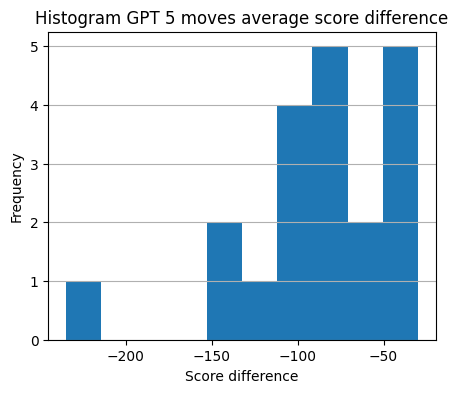

---------------------------------------
Random:
 - Average score difference after move: -135.9060524565329
 - Total number of best moves: 50
 - Total number of worst moves: 33
 - Total number of above average moves: 869


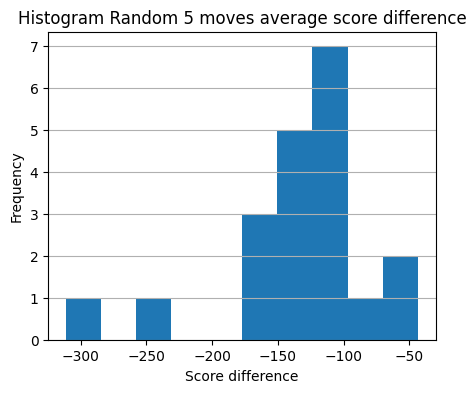

Number of moves before evaluation: 10
---------------------------------------
GPT-2:
 - Average score difference after move: -203.7580085144863
 - Total number of legal moves: 859 / 4000
 - Total number of best moves: 61
 - Total number of worst moves: 9
 - Total number of above average moves: 655


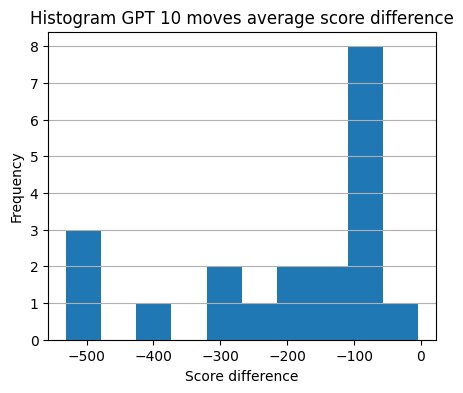

---------------------------------------
Random:
 - Average score difference after move: -256.1460151956516
 - Total number of best moves: 30
 - Total number of worst moves: 25
 - Total number of above average moves: 539


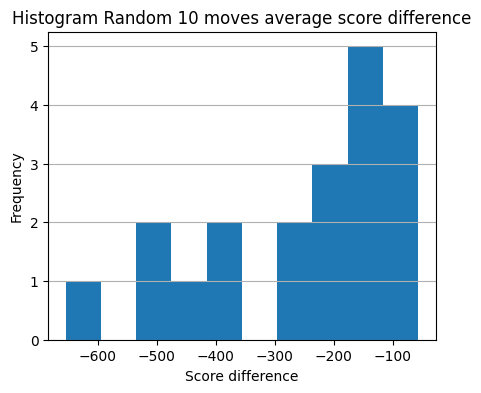

Number of moves before evaluation: 15
---------------------------------------
GPT-2:
 - Average score difference after move: -242.08344825972978
 - Total number of legal moves: 596 / 3600
 - Total number of best moves: 38
 - Total number of worst moves: 7
 - Total number of above average moves: 379


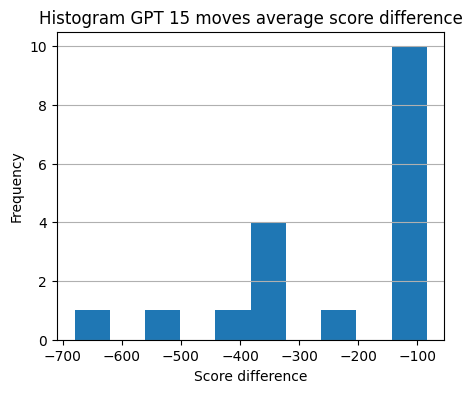

---------------------------------------
Random:
 - Average score difference after move: -276.2473048363578
 - Total number of best moves: 16
 - Total number of worst moves: 17
 - Total number of above average moves: 328


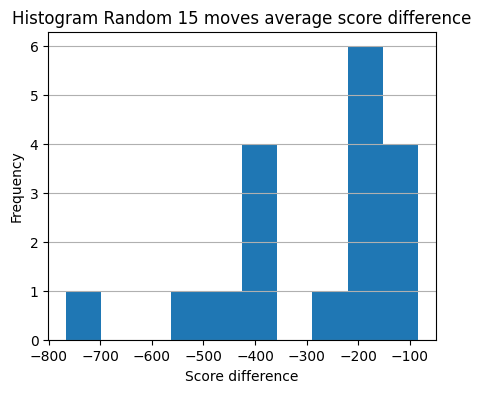

Number of moves before evaluation: 20
---------------------------------------
GPT-2:
 - Average score difference after move: -314.8889247064372
 - Total number of legal moves: 523 / 3600
 - Total number of best moves: 29
 - Total number of worst moves: 8
 - Total number of above average moves: 298


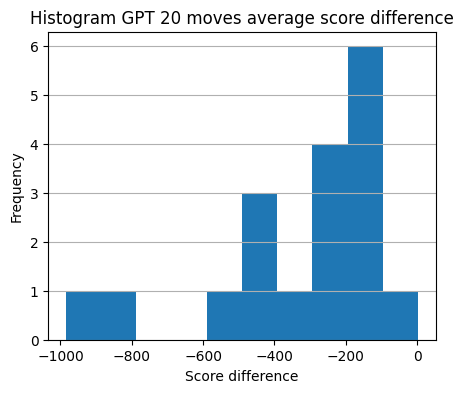

---------------------------------------
Random:
 - Average score difference after move: -348.585851399529
 - Total number of best moves: 14
 - Total number of worst moves: 12
 - Total number of above average moves: 269


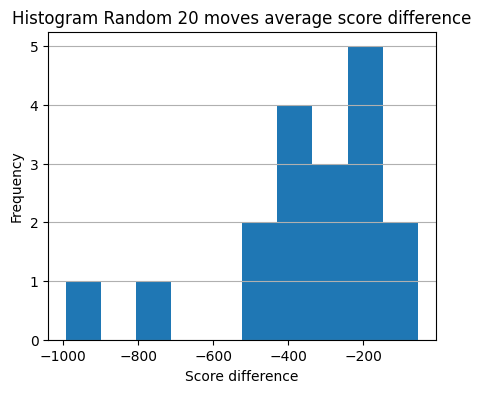

Aggregate results GPT-2
 - Average score difference after move: -211.7014815994193
 - Total number of legal moves: 3163 / 12037
 - Total number of best moves: 234
 - Total number of worst moves: 30
 - Total number of above average moves: 2384
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -254.22130597201783
 - Total number of best moves: 110
 - Total number of worst moves: 87
 - Total number of above average moves: 2005


In [23]:
show_results_single_eval(summaries, tests_num_moves)

#### Test 2: same tests but try to force legal moves

Issues: 
- Every elemnt of a move is treated as separate tokens, random combinations of these tokens at output.
- Since we cannot set ```do_sample=True``` in this scenario (prohibited with forced words), generate one output for more games.

In [114]:
class AlternativesPipeline(TextGenerationPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, *args, force_words=None, **kwargs):
        force_words_ids = [
            self.tokenizer(force_words, add_special_tokens=False).input_ids
        ]

        kwargs["force_words_ids"] = force_words_ids
        return super().__call__(*args, **kwargs)
    
forced_generator = AlternativesPipeline(
    model=GPT2LMHeadModel.from_pretrained("gpt2", no_repeat_ngram_size=1, remove_invalid_values=True).to("cuda"),
    tokenizer=GPT2Tokenizer.from_pretrained("gpt2"),
    device=0
)

model_config = forced_generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups, model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size, model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1, False)
(1.0, 50)
(20, 1, True)
1



In [132]:
alternatives = ["dog"]

print(forced_generator("What is your favorite animal? A:", max_length=25, truncation=True, 
                  pad_token_id=forced_generator.tokenizer.eos_token_id, 
                  force_words=alternatives, num_return_sequences=1, num_beams=10)[0]["generated_text"])

What is your favorite animal? A: Well, I'm a big fan of dogs and cats. They're my petdog


In [262]:
num_moves = [5, 10, 15, 20]
transcripts = test_data_moves["transcript"][:100]
summaries = run_legal_forced_test(transcripts, num_moves, stockfish, generator, forced_generator)

Tests for 5 moves


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Tests for 10 moves


100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


Tests for 15 moves


100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


Tests for 20 moves


100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


Number of moves before evaluation: 5
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -88.79310344827586
 - Total number of legal moves: 29 / 99
 - Total number of best moves: 2
 - Total number of worst moves: 1
 - Total number of above average moves: 25


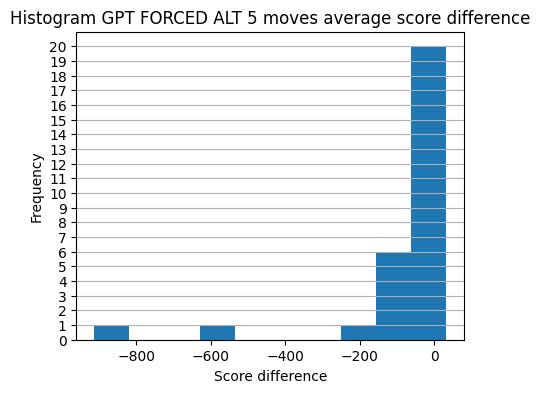

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -97.22222222222223
 - Total number of legal moves: 36 / 99
 - Total number of best moves: 2
 - Total number of worst moves: 0
 - Total number of above average moves: 29


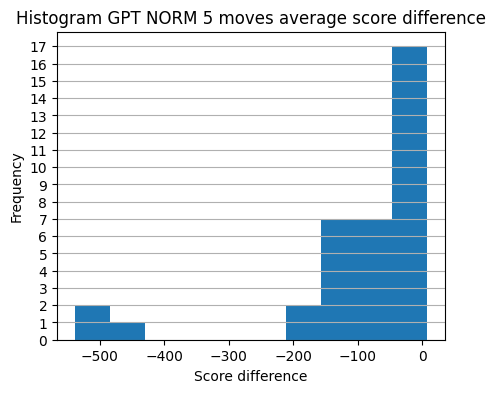

---------------------------------------
Random:
 - Average score difference after move: -167.13793103448276
 - Total number of best moves: 1
 - Total number of worst moves: 2
 - Total number of above average moves: 17


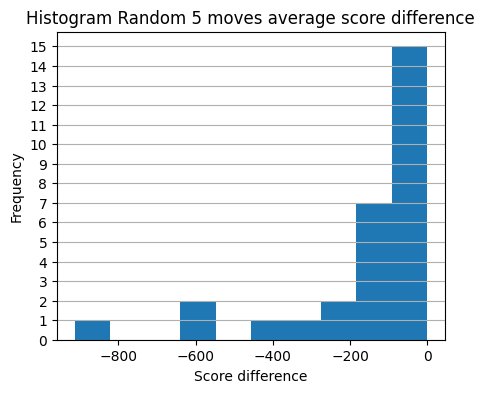

Number of moves before evaluation: 10
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Total number of legal moves: 0 / 99
 - Total number of best moves: 0
 - Total number of worst moves: 0
 - Total number of above average moves: 0
No correct moves
---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -151.6086956521739
 - Total number of legal moves: 23 / 99
 - Total number of best moves: 2
 - Total number of worst moves: 0
 - Total number of above average moves: 16


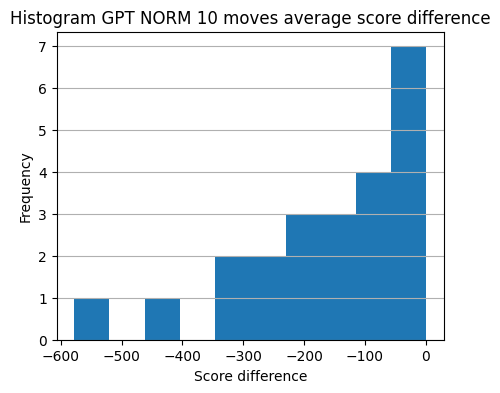

No correct forced model moves, no random comparison
Number of moves before evaluation: 15
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -185.44444444444446
 - Total number of legal moves: 18 / 97
 - Total number of best moves: 1
 - Total number of worst moves: 0
 - Total number of above average moves: 14


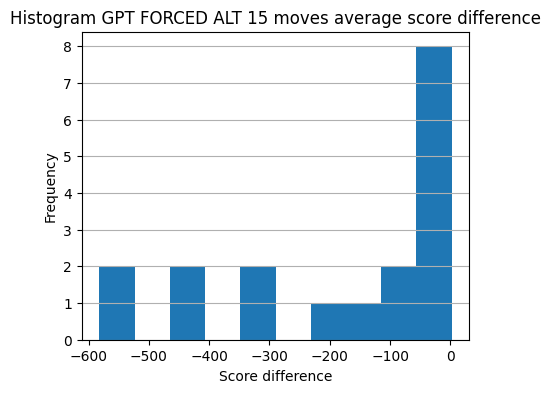

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -182.7058823529412
 - Total number of legal moves: 17 / 97
 - Total number of best moves: 1
 - Total number of worst moves: 0
 - Total number of above average moves: 12


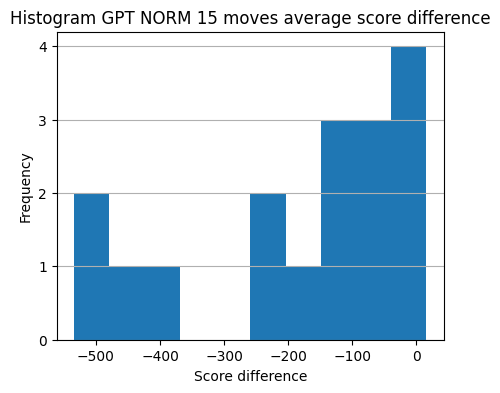

---------------------------------------
Random:
 - Average score difference after move: -189.83333333333334
 - Total number of best moves: 0
 - Total number of worst moves: 0
 - Total number of above average moves: 13


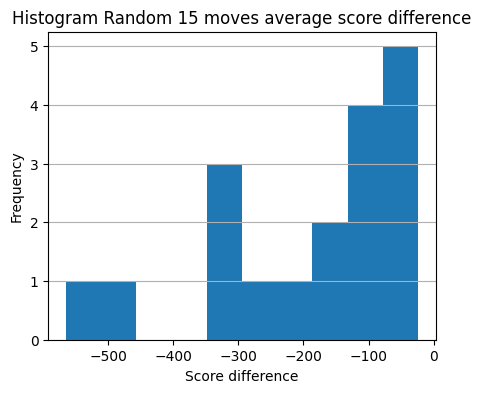

Number of moves before evaluation: 20
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -214.25
 - Total number of legal moves: 4 / 96
 - Total number of best moves: 0
 - Total number of worst moves: 0
 - Total number of above average moves: 3


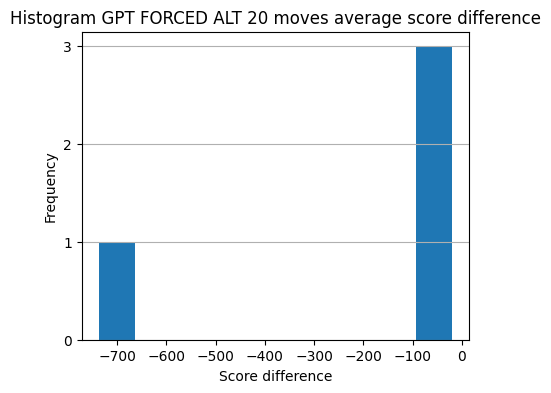

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -253.06666666666666
 - Total number of legal moves: 15 / 96
 - Total number of best moves: 3
 - Total number of worst moves: 0
 - Total number of above average moves: 10


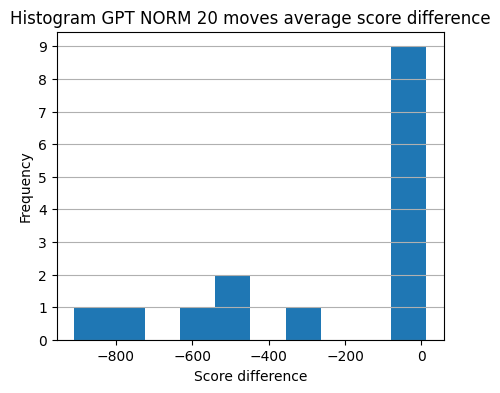

---------------------------------------
Random:
 - Average score difference after move: -298.5
 - Total number of best moves: 0
 - Total number of worst moves: 0
 - Total number of above average moves: 2


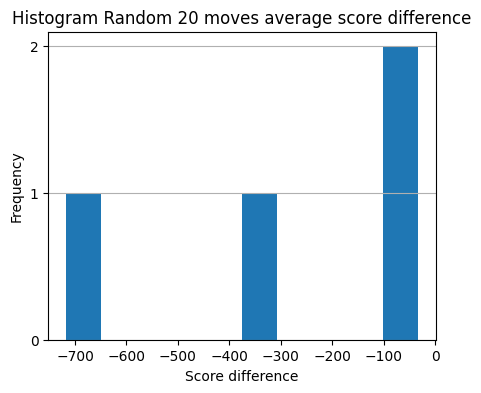

Aggregate results GPT-2 FORCED ALTERNATIVES
 - Average score difference after move: -162.829
 - Total number of legal moves: 51 / 391
 - Total number of best moves: 3
 - Total number of worst moves: 1
 - Total number of above average moves: 42
----------------------------------------------------------------
Aggregate results GPT-2 NORMAL
 - Average score difference after move: -171.151
 - Total number of legal moves: 91 / 391
 - Total number of best moves: 8
 - Total number of worst moves: 0
 - Total number of above average moves: 67
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -218.49
 - Total number of best moves: 1
 - Total number of worst moves: 2
 - Total number of above average moves: 32


In [263]:
show_results_forced_test(summaries, num_moves)

#### Test 3: play against a random player

Starting position:


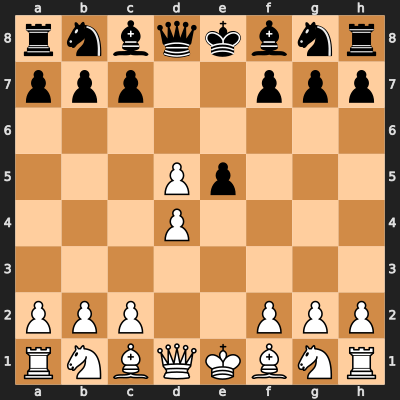

Player: GPT-2 | Color: BLACK | Move: Nc6


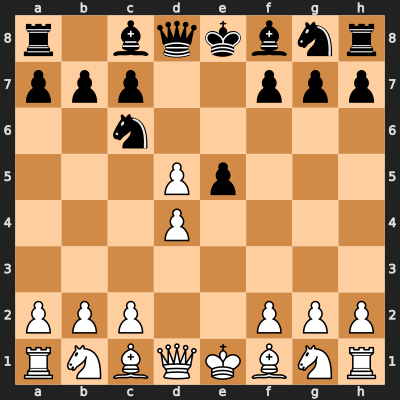

Player: Random | Color: WHITE | Move: Nf3


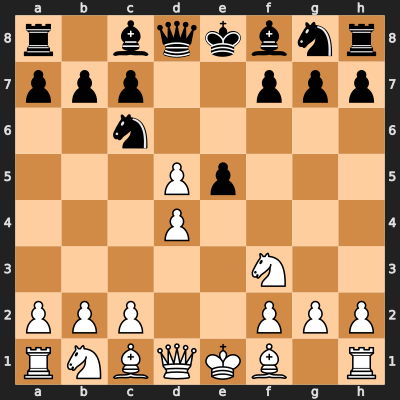

Player: GPT-2 | Color: BLACK | Move: g6


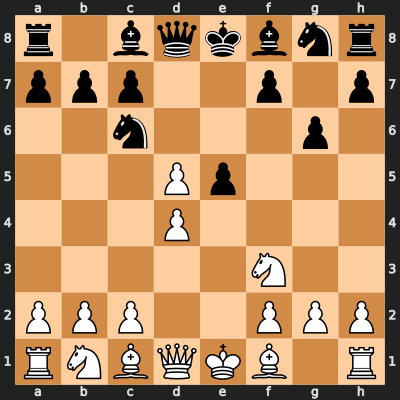

Player: Random | Color: WHITE | Move: Ba6


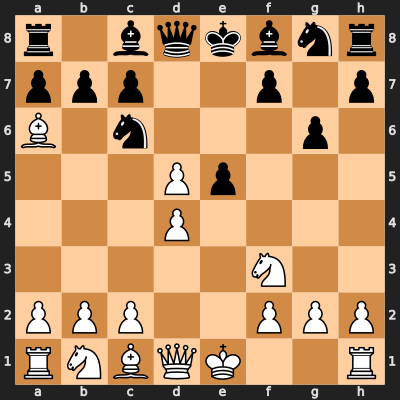

Player: GPT-2 | Color: BLACK | Move: e4


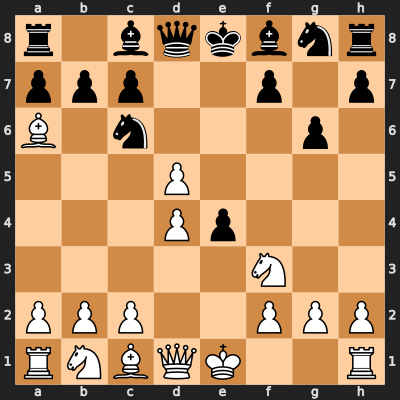

Player: Random | Color: WHITE | Move: dxc6


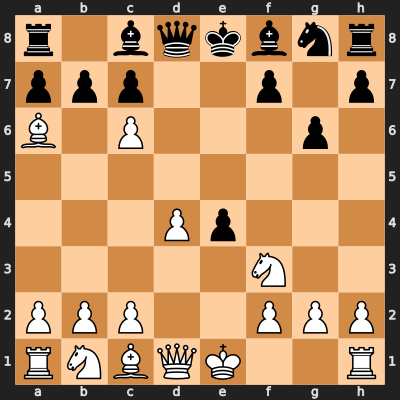

In [274]:
play_game_vs_random(test_data_moves["transcript"][0], 5, generator, max_iters=3, verbose=True, display_board=True)

#### Test x: appending moves

In [23]:
# transcript = test_data_moves['transcript'][0]
# board, moves = get_state_after_moves(transcript, 3)

# while not board.is_checkmate():
#     next_moves = generate_next_moves(moves, generator, tokenizer)
#     next_move = [move for move in next_moves[0].split(" ") if move[0].isalpha()][0]

#     legal_moves = get_san_legal_moves(board)
#     if next_move in legal_moves:
#         board.push_san(next_move)
#         show_board(board)
#         moves += " " + next_move
#         print(moves)

## Evaluation based on game board

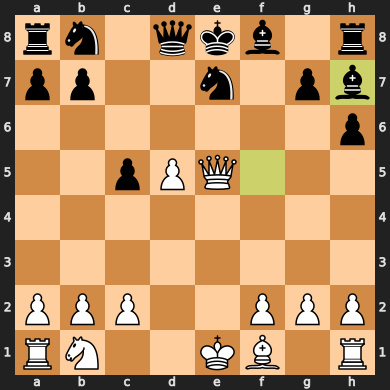

In [18]:
board = chess.Board()
game = test_data_moves[0]["transcript"].split(" ")
res = game[-1]
game = [[x, y] for x, y in zip(game[1::3], game[2::3])]

for turn in game[:10]:
    board.push_san(turn[WHITE])
    board.push_san(turn[BLACK])

board

In [19]:
get_stockfish_scores(board, stockfish, board.turn, time_limit=0.1), "WHITE" if chess.WHITE == board.turn else "BLACK"

((-46, -5, -211), 'WHITE')

In [20]:
generate_answer(generator, f"Provide the next move in the chess game. Only provide the move, no move numbers. {board.fen()}. Next move is A:", max_len=100)

['Provide the next move in the chess game. Only provide the move, no move numbers. rn1qkb1r/pp2n1pb/7p/2pPQ3/8/8/PPP2PPP/RN2KB1R w KQkq - 0 11. Next move is A: Q, A 2 Q P P, Q Z S Y A CQ B Q Y A Q Q B Y B KY D C B']

In [22]:
test_data.board.iloc[0]

'r4b1r/pp1bnkp1/1q2B3/2ppP2p/5P2/2PP1K1P/PP1N4/R1B2R2 b - - 0 19'

In [23]:
board = chess.Board(test_data.board.iloc[0])

print(board)

r . . . . b . r
p p . b n k p .
. q . . B . . .
. . p p P . . p
. . . . . P . .
. . P P . K . P
P P . N . . . .
R . B . . R . .


In [27]:
generate_answer(generator, f"Provide the next move in the chess game. Only provide the move, no move numbers. {board.__str__()}. Next move is A:", max_len=150)

['Provide the next move in the chess game. Only provide the move, no move numbers. r . . . . b . r\np p . b n k p .\n. q . . B . . .\n. . p p P . . p\n. . . . . P . .\n. . P P . K . P\nP P . N . . . .\nR . B . . R . .. Next move is A: b.\n. q b p p p q q p p B: s p p p p p\nB. S. p p p p p v. p p\nS. S.. p p p p P p. P\nS. S..']